## 制約付き最適化自体が難しいので，制約範囲外の場合に獲得関数の値を低くする方法で実験

In [1]:

"""
利用可能な最適化手法
"SLSQP" (Sequential Least Squares Programming):

制約付き非線形最適化に適している
勾配情報を使用
デフォルトの手法
"L-BFGS-B" (Limited-memory BFGS with Bounds):

大規模な最適化問題に適している
境界制約のみをサポート
メモリ効率が良い
"COBYLA" (Constrained Optimization BY Linear Approximation):

勾配を必要としない
非線形制約をサポート
ロバストだが収束が遅い場合がある
"trust-constr" (Trust Region Constrained):

より高度な制約付き最適化
二次収束性を持つ
計算コストが高い
"Nelder-Mead":

勾配を必要としない
単純シンプレックス法
制約なし最適化向け
推奨される使用場面
制約付き最適化: "SLSQP" または "trust-constr"
大規模問題: "L-BFGS-B"
勾配計算が困難: "COBYLA" または "Nelder-Mead"
これらの手法は scipy.optimize.minimize の実装を使用しています。
"""

'\n利用可能な最適化手法\n"SLSQP" (Sequential Least Squares Programming):\n\n制約付き非線形最適化に適している\n勾配情報を使用\nデフォルトの手法\n"L-BFGS-B" (Limited-memory BFGS with Bounds):\n\n大規模な最適化問題に適している\n境界制約のみをサポート\nメモリ効率が良い\n"COBYLA" (Constrained Optimization BY Linear Approximation):\n\n勾配を必要としない\n非線形制約をサポート\nロバストだが収束が遅い場合がある\n"trust-constr" (Trust Region Constrained):\n\nより高度な制約付き最適化\n二次収束性を持つ\n計算コストが高い\n"Nelder-Mead":\n\n勾配を必要としない\n単純シンプレックス法\n制約なし最適化向け\n推奨される使用場面\n制約付き最適化: "SLSQP" または "trust-constr"\n大規模問題: "L-BFGS-B"\n勾配計算が困難: "COBYLA" または "Nelder-Mead"\nこれらの手法は scipy.optimize.minimize の実装を使用しています。\n'

In [2]:
from botorch.test_functions import Ackley, Branin
import torch
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_mll
from botorch.optim import optimize_acqf
from botorch.acquisition import qExpectedImprovement
import numpy as np
import matplotlib.pyplot as plt
from botorch.utils.transforms import unnormalize

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/yusaku/opt/anaconda3/envs/bo/lib/python3.11/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403212643/work/aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)
/Users/yusaku/opt/anaconda3/envs/bo/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-2.6937], dtype=torch.float64), std = tensor([nan], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/yusaku/opt/anaconda3/envs/bo/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


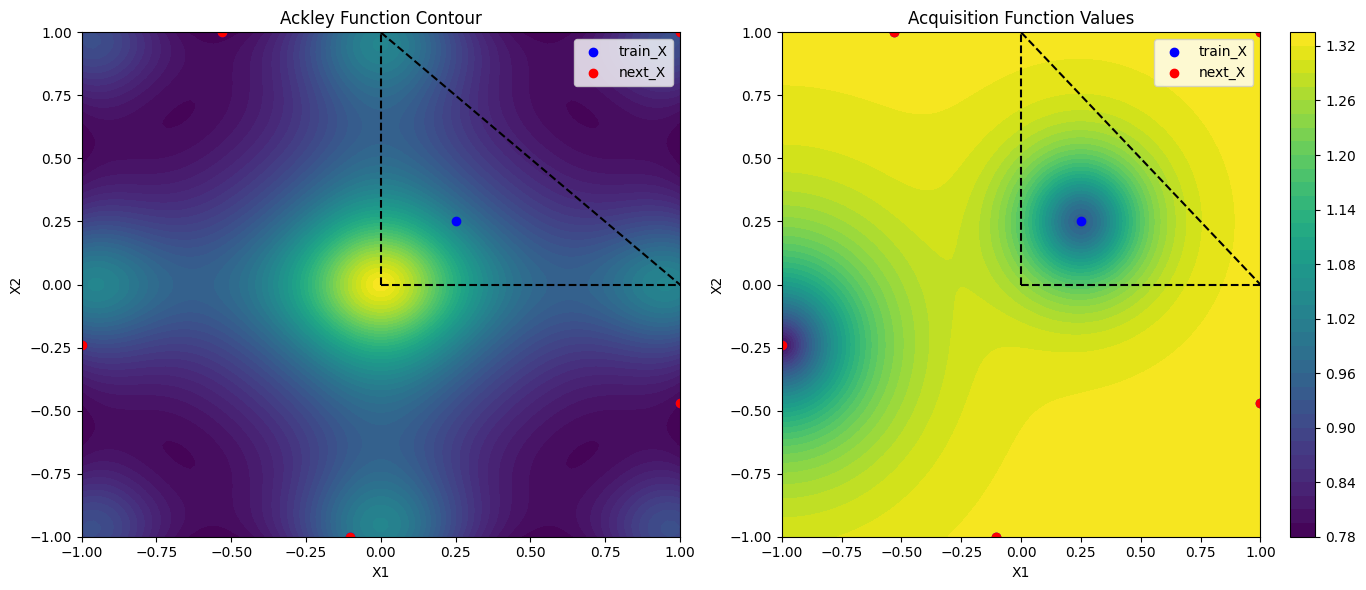

In [3]:
func = Ackley(negate=True)
bounds  = torch.tensor([[-1.,-1.],[1.,1.]])
train_X = torch.tensor([[0.25, 0.25]], dtype=torch.float64)
train_y = func(train_X).unsqueeze(-1)

iteration = 1
#train_X = unnormalize(train_X, bounds)

for iter in range(1, iteration + 1):
    model = SingleTaskGP(train_X, train_y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    qEI = qExpectedImprovement(model, train_y.max())
    
    candidates, _ = optimize_acqf(
            acq_function=qEI,
            bounds=bounds,
            q=1,
            num_restarts=20,
            raw_samples=512,
        )
    within_bounds = (candidates[:, 0] > 0) & (candidates[:, 1] > 0) & ((candidates[:, 0] + candidates[:, 1]) < 3)
    # Update acquisition values for candidates that do not meet the constraints
    for i, candidate in enumerate(candidates):
        if not within_bounds[i]:
            qEI.set_X_pending(candidate.unsqueeze(0))
            qEI_values = qEI(candidate.unsqueeze(0))
            qEI_values.fill_(-1e6)  # Set a very low value for candidates not meeting constraints


    train_X = torch.cat([train_X, candidates], dim=-2)
    train_y = torch.cat([train_y, func(candidates).unsqueeze(-1)], dim=-2)

    # Calculate next_X
    next_X = candidates

    # Plotting the contour of the Ackley function
    x = np.linspace(-1, 1, 100)
    y = np.linspace(-1, 1, 100)
    #x = np.linspace(bounds[0, 0].item(), bounds[1, 0].item(), 100)
    #y = np.linspace(bounds[0, 1].item(), bounds[1, 1].item(), 100)
    X, Y = np.meshgrid(x, y)
    Z = np.array([[func(torch.tensor([[xx, yy]], dtype=torch.float64)).item() for xx in x] for yy in y])

    # Plotting the constraint x0 > 0, x1 > 0, x0 + x1 < 3
    constraint_x = np.linspace(0, 1, 100)
    constraint_y1 = np.zeros_like(constraint_x)
    constraint_y2 = 1 - constraint_x

    # Calculate acquisition function values for the grid
    acq_values = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            point = torch.tensor([[X[i, j], Y[i, j]]], dtype=torch.float64)
            acq_values[i, j] = qEI(point).item()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # 左側: Ackley関数のコンター図
    ax1.contourf(X, Y, Z, levels=50)
    ax1.plot(constraint_x, constraint_y1, 'k--')
    ax1.plot(constraint_y1, constraint_x, 'k--')
    ax1.plot(constraint_x, constraint_y2, 'k--')
    ax1.scatter(train_X[:, 0].numpy(), train_X[:, 1].numpy(), color='blue', label='train_X')
    ax1.scatter(next_X[:, 0].numpy(), next_X[:, 1].numpy(), color='red', label='next_X')
    ax1.set_title('Ackley Function Contour')
    ax1.set_xlabel('X1')
    ax1.set_ylabel('X2')
    ax1.legend()

    # 右側: アクイジション関数のコンター図と散布図
    contour = ax2.contourf(X, Y, acq_values, levels=50)
    ax2.plot(constraint_x, constraint_y1, 'k--')
    ax2.plot(constraint_y1, constraint_x, 'k--')
    ax2.plot(constraint_x, constraint_y2, 'k--')
    ax2.scatter(train_X[:, 0].numpy(), train_X[:, 1].numpy(), color='blue', label='train_X')
    ax2.scatter(next_X[:, 0].numpy(), next_X[:, 1].numpy(), color='red', label='next_X')
    ax2.set_title('Acquisition Function Values')
    ax2.set_xlabel('X1')
    ax2.set_ylabel('X2')
    ax2.legend()

    plt.colorbar(contour, ax=ax2)
    plt.tight_layout()
    plt.show()

/Users/yusaku/opt/anaconda3/envs/bo/lib/python3.11/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403212643/work/aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)
/Users/yusaku/opt/anaconda3/envs/bo/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-2.6937], dtype=torch.float64), std = tensor([nan], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


len(candidates): 0
len(X_pending): 0
Point outside constraints: x1=1.000, x2=1.000
len(candidates): 0
len(X_pending): 1
Point outside constraints: x1=0.000, x2=1.000
len(candidates): 0
len(X_pending): 2
Point outside constraints: x1=1.000, x2=0.000
len(candidates): 0
len(X_pending): 3
Point outside constraints: x1=0.000, x2=0.000
len(candidates): 0
len(X_pending): 4
Point outside constraints: x1=0.576, x2=0.632
len(candidates): 0
len(X_pending): 5
Point outside constraints: x1=1.000, x2=0.445
len(candidates): 0
len(X_pending): 6
Point outside constraints: x1=0.000, x2=0.573
len(candidates): 0
len(X_pending): 7
Point outside constraints: x1=0.590, x2=0.000
len(candidates): 0
len(X_pending): 8
Point outside constraints: x1=0.489, x2=1.000
len(candidates): 0
len(X_pending): 9
Point outside constraints: x1=1.000, x2=0.697
len(candidates): 0
len(X_pending): 10
Point within constraints: x1=0.272, x2=0.681
Sum: 0.953
len(candidates): 1
len(X_pending): 11
Point within constraints: x1=0.626, x2

/Users/yusaku/opt/anaconda3/envs/bo/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-8.3621], dtype=torch.float64), std = tensor([2.9460], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/yusaku/opt/anaconda3/envs/bo/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


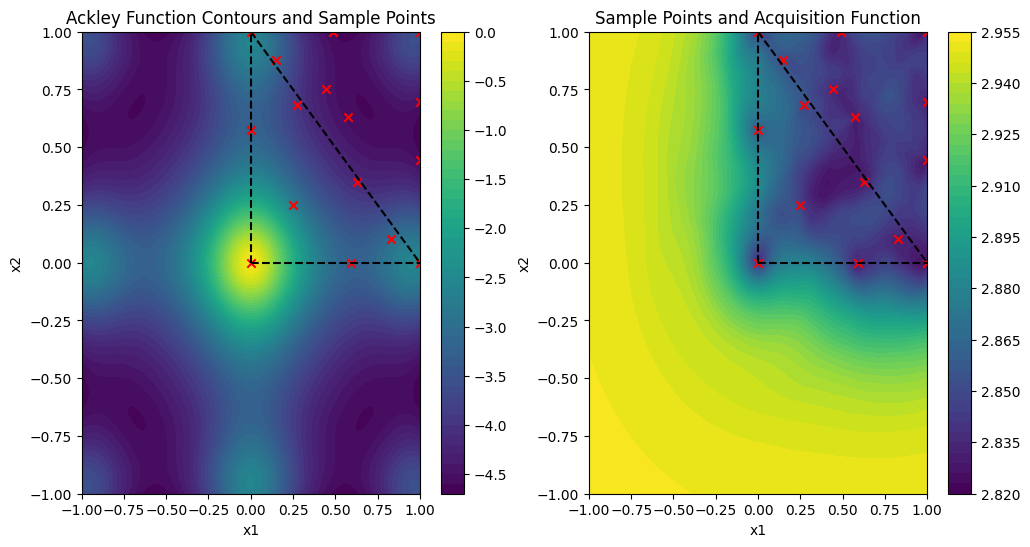

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from botorch.models import SingleTaskGP
from botorch.acquisition import qExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import ScaleKernel, RBFKernel
from botorch import fit_gpytorch_mll
from botorch.test_functions import Ackley

# Ackley関数の定義
ackley = Ackley(negate=True)

# ダミーデータの生成

bounds  = torch.tensor([[-1.,-1.],[1.,1.]])
train_X = torch.tensor([[0.25, 0.25]], dtype=torch.float64)
train_Y = ackley(train_X).unsqueeze(-1)

# ガウス過程モデルの定義
model = SingleTaskGP(train_X, train_Y)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)

# 獲得関数の定義（UCBとして）
qEI = qExpectedImprovement(model, train_Y.max())

# 最適化領域の定義
bounds = torch.stack([torch.zeros(2), torch.ones(2)])  # 2次元の探索空間

# 候補点の取得
candidates = []
X_pending = []
while len(candidates) < 3:
    print("len(candidates):",len(candidates))
    print("len(X_pending):",len(X_pending))
    candidate, _ = optimize_acqf(
        acq_function=qEI,
        bounds=bounds,
        q=1,
        num_restarts=10,
        raw_samples=100,
    )

    # 0 < x1 < 1 の範囲チェック
    if (0 < candidate[0, 0].item() < 1 and 0 < candidate[0, 1].item() < 1 and candidate[0, 0].item() + candidate[0, 1].item() < 1):
        print(f"Point within constraints: x1={candidate[0, 0].item():.3f}, x2={candidate[0, 1].item():.3f}")
        print(f"Sum: {(candidate[0, 0].item() + candidate[0, 1].item()):.3f}")
        candidates.append(candidate)
        X_pending.append(candidate)
    else:
        train_X = torch.cat((train_X, candidate), dim=0)
        train_Y = torch.cat((train_Y, torch.tensor([-10.0]).unsqueeze(-1)), dim=0)

        # ガウス過程モデルの再フィッティング
        #model = SingleTaskGP(train_X, train_Y)
        #mll = ExactMarginalLogLikelihood(model.likelihood, model)
        #fit_gpytorch_mll(mll)
        X_pending.append(candidate)
        print(f"Point outside constraints: x1={candidate[0, 0].item():.3f}, x2={candidate[0, 1].item():.3f}")
    
    # 影響範囲を避けるように設定
    if len(X_pending) > 0:
        qEI.set_X_pending(torch.cat(X_pending, dim=0))

# 範囲内の候補が3+1点に達した段階での再学習
new_X = torch.cat(candidates, dim=0)
new_Y = ackley(new_X).unsqueeze(-1)  # Ackley関数のターゲット値
train_X = torch.cat((train_X, new_X), dim=0)
train_Y = torch.cat((train_Y, new_Y), dim=0)

# ガウス過程モデルの再フィッティング
model = SingleTaskGP(train_X, train_Y)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)

# Ackley関数の等高線プロット
x1 = np.linspace(-1, 1, 100)
x2 = np.linspace(-1, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.vstack([X1.ravel(), X2.ravel()]).T
Z = ackley(torch.tensor(X_grid)).reshape(100, 100)

# 等高線図とサンプル点
# 制約条件の直線
constraint_x = np.linspace(0, 1, 100)
constraint_y1 = 1 - constraint_x  # x1 + x2 = 1
constraint_y2 = np.zeros_like(constraint_x)  # x2 = 0

# プロット

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.contourf(X1, X2, Z, levels=50)
plt.colorbar()
plt.scatter(train_X[:, 0].numpy(), train_X[:, 1].numpy(), color='red', marker='x')
plt.plot(constraint_x, constraint_y1, 'k--', label='x1 + x2 = 1')  # 斜めの制約線
plt.plot(constraint_x, constraint_y2, 'k--', label='x2 = 0')       # x軸
plt.plot(constraint_y2, constraint_x, 'k--', label='x1 = 0')  
plt.title('Ackley Function Contours and Sample Points')
plt.xlabel('x1')
plt.ylabel('x2')


# 獲得関数の値とサンプル点
X_grid_tensor = torch.tensor(X_grid, dtype=torch.float32)

acq_values = np.zeros_like(X1)
for i in range(X1.shape[0]):
    for j in range(X1.shape[1]):
        point = torch.tensor([[X1[i, j], X2[i, j]]], dtype=torch.float64)
        acq_values[i, j] = qEI(point).item()
plt.subplot(1, 2, 2)
plt.contourf(X1, X2, acq_values, levels=50)
plt.colorbar()
plt.scatter(train_X[:, 0].numpy(), train_X[:, 1].numpy(), color='red', marker='x')
plt.plot(constraint_x, constraint_y1, 'k--', label='x1 + x2 = 1')  # 斜めの制約線
plt.plot(constraint_x, constraint_y2, 'k--', label='x2 = 0')       # x軸
plt.plot(constraint_y2, constraint_x, 'k--', label='x1 = 0')  
plt.title('Sample Points and Acquisition Function')
plt.xlabel('x1')
plt.ylabel('x2')

plt.show()


In [23]:
aaa=qEI(X_grid_tensor).detach().numpy()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [31]:
print(candidate[0, 1].item())

0.0
